In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:

%cd /content/gdrive/My Drive/prospective_study

 

/content/gdrive/My Drive/DnCNN-keras-master/DnCNN-keras-master


In [ ]:
!pip install bm3d
!pip install pydicom
!pip install medpy
!pip install image-quality

In [ ]:
# This code is for prospective high b-value DWI denoising using DnCNN
# Code dependency Python 3.7, Tesnsorflow and Keras
# Reference article: https://ieeexplore.ieee.org/abstract/document/7839189

import os
import cv2
import logging
import time 
import glob
import os.path
import models
import bm3d
import pydicom
import nibabel as nib
import numpy as np
import pandas as pd
import scipy
from scipy import stats 
from scipy.stats import rice
from scipy import ndimage
#from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
#import imquality.brisque as brisque
import skimage.measure    
from keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.optimizers import Adam
from skimage.measure import compare_psnr, compare_ssim
#from skimage.metrics import structural_similarity as ssim
from medpy.filter.smoothing import anisotropic_diffusion   
from skimage import data
from math import log10, sqrt
from skimage.filters import unsharp_mask
from skimage import filters
from skimage import restoration
from skimage.filters import threshold_local,threshold_yen

 


In [ ]:
# Parameters
class Args:
      model='DnCNN'
      batch_size=128
      train_dataX='/content/gdrive/MyDrive/prospective_study/data/npy_data/x_train_avg1_128_23.npy'
      #train_dataX='/content/gdrive/MyDrive/prospective_study/data/npy_data/x_train_avg2_128_23.npy'
      #train_dataX='/content/gdrive/MyDrive/prospective_study/data/npy_data/x_train_avg4_128_23.npy'
      train_dataY='/content/gdrive/MyDrive/prospective_study/data/npy_data/y_train_avg10_128_foravg1_23.npy'
      test_dir='../prospective_study/data/Test/'
      nex=1                       # given signal average 1,2,4
      epoch=100
      lr=1e-3
      pretrain=None
      only_test=False
args=Args()

# PSNR function definition
def PSNR(original,denoised,mask):
    original_mask=mask*original
    denoised_mask=mask*denoised
    mse = np.mean((original_mask - denoised_mask) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 0
    max_pixel = 1.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr


In [ ]:
# This section is to save information log  in snapshot directory
if not args.only_test:
    save_dir = './snapshot/save_'+ args.model + '_' + 'nex' + str(args.sigma) + '_' + time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime()) + '/'
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    # log
    logging.basicConfig(level=logging.INFO,format='%(asctime)s %(filename)s[line:%(lineno)d] %(levelname)s %(message)s',
                    datefmt='%Y %H:%M:%S',
                    filename=save_dir+'info.log',
                    filemode='w')
    console = logging.StreamHandler()
    console.setLevel(logging.INFO)
    formatter = logging.Formatter('%(name)-6s: %(levelname)-6s %(message)s')
    console.setFormatter(formatter)
    logging.getLogger('').addHandler(console)
    
    logging.info(args)
    
else:
    save_dir = '/'.join(args.pretrain.split('/')[:-1]) + '/'

root  : INFO   <__main__.Args object at 0x7fb6e2a425d0>


In [ ]:
# Training:
# Skip training if you are using saved model
# Train and test split for b3000 data

X_train_before_split= np.load(args.train_dataX)
#X_train1= np.load(args.train_dataX)    # Use this if there is no splitting X_train

X_train1,x_test_split = train_test_split(X_train_before_split,test_size=0.1,train_size=0.9,shuffle=False)
#Y_train1= np.load(args.train_dataY)    # Use this if there is no splitting  Y_train
Y_train_before_split= np.load(args.train_dataY)
Y_train1,y_test_split = train_test_split(Y_train_before_split,test_size=0.1,train_size=0.9,shuffle=False)
   
# Normalize for b3000 data
X_train1= X_train1.reshape((X_train1.shape[0],X_train1.shape[1],X_train1.shape[2],1))
X_train1 = X_train1.astype('float32')
X_train1= X_train1/np.max(X_train1)
Y_train1= Y_train1.reshape((Y_train1.shape[0],Y_train1.shape[1],Y_train1.shape[2],1))
Y_train1 = Y_train1.astype('float32')
Y_train1 = Y_train1/np.max(Y_train1)
logging.info('Size of train data: ({}, {}, {})'.format(X_train1.shape[0],X_train1.shape[1],X_train1.shape[2]))
logging.info('Size of train data: ({}, {}, {})'.format(Y_train1.shape[0],Y_train1.shape[1],Y_train1.shape[2]))


       

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':


(128, 128, 120)
(128, 128, 120)


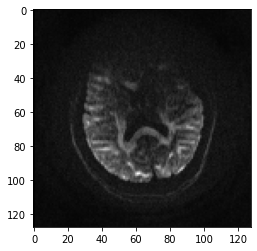

In [ ]:
# Read NEX 10 gold standard data
x_sub1_10=[]

for dirpath, dirnames, filenames in os.walk('../prospective_study/data/'):
    for filename in [f for f in filenames if f.endswith("b3000_avg10_full_128_sub2.nii")]:
        img_path=os.path.join(dirpath, filename)
        img = nib.load(os.path.join(dirpath, filename))
        
        #read data
        x_test_nifti = np.array(img.get_data())     
        slice_total=x_test_nifti.shape[2]
        for num_slice in range(slice_total):
            x_test=x_test_nifti[:,:,num_slice]
            x_test=np.rot90(x_test,3)
            x_test=np.fliplr(x_test)
            x_test=x_test/np.max(x_test)
            x_test=x_test.astype('float32')
            x_sub1_10.append(x_test)                    
            x_sub10=np.asarray(x_sub1_10)
            
        x_sub10=np.transpose(x_sub10)
        print(x_sub10.shape)
        %matplotlib inline
        plt.imshow(x_sub10[:,:,69],cmap='gray')

    
         

In [ ]:

#step decay
def step_decay(epoch):
    initial_lr = args.lr
    if epoch<50:
        lr = initial_lr
    else:
        lr = initial_lr/10
    return lr

In [ ]:

# model selection
if args.pretrain:   model = load_model(args.pretrain, compile=False) # If it is pretrained model
else:   
    if args.model == 'DnCNN': model = models.DnCNN()

# compile the model
model.compile(optimizer='Adam',loss='mse')
#print(model.summary())
lr = LearningRateScheduler(step_decay)


In [ ]:

# train
# Execute this cell iff you are training the model with b3000 DWI

es = EarlyStopping(monitor='loss', mode='min', min_delta=1e-3,patience=4)
ckpt = ModelCheckpoint(save_dir+'/model_{epoch:02d}.h5', monitor='loss', 
                    verbose=0, period=args.save_every,save_weights_only=True,
                    mode='min',
                    save_best_only=True)
csv_logger = CSVLogger(save_dir+'/log.csv', append=True, separator=',')

lr = LearningRateScheduler(step_decay)
    # train 
start = time.time()
history = model.fit(X_train1,Y_train1, batch_size=args.batch_size,
                steps_per_epoch=len(X_train1)//args.batch_size, epochs=args.epoch, verbose=1,callbacks=[es]) 
stop = time.time()

print(f"Training time: {stop - start}s")
model.save('../DnCNN-keras-master/model_0.03_final1/')  # Save the model for future use



tensorflow: WARNING `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


Epoch 1/60
1710/1710 [==============================] - 687s 388ms/step - loss: 1.4025
Epoch 2/60
1710/1710 [==============================] - 661s 386ms/step - loss: 0.0059
Epoch 3/60
1710/1710 [==============================] - 661s 387ms/step - loss: 0.0379
Epoch 4/60
1710/1710 [==============================] - 656s 384ms/step - loss: 0.0083
Epoch 5/60
1710/1710 [==============================] - 653s 382ms/step - loss: 0.0058
Epoch 6/60
1710/1710 [==============================] - 655s 383ms/step - loss: 0.0047
Training time: 3973.0144062042236s


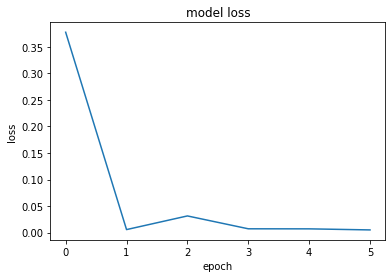

In [ ]:
#Plot training loss curve
%matplotlib inline
train_loss=history.history['loss']
plt.plot(train_loss)   
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Run this cell to load saved model with b3000 DWI

#loaded_model = tf.keras.models.load_model('../prospective_study/model_avg1_final_23/')
loaded_model = tf.keras.models.load_model('../prospective_study/model_avg2_final_23/')
#loaded_model = tf.keras.models.load_model('../prospective_study/model_avg4_final_23/')
model = loaded_model

In [ ]:
# Testing for all the slices of one subject at a time
# Run this cell if denoising prospective DWI data


print('Start to test on {}'.format(args.test_dir))
out_dir = save_dir + args.test_dir.split('/')[-1] + '/'
if not os.path.exists(out_dir):
        os.mkdir(out_dir)
        
im_data=[] 
name = []
psnr = []
psnr_sub2=[]
ssim = []
ssim_sub2=[]
entropy_dn=[]
entropy_n=[]
psnr_bm=[]
psnr_bl=[]
psnr_ad=[]
psnr_tv=[]
ssim_bm=[]
ssim_bl=[]
ssim_ad=[]
ssim_tv=[]
entropy_bl=[]
entropy_bm=[]
entropy_ad=[]
entropy_tv=[]
count=0
denoised_nifti=[]



# Read test images

for dirpath, dirnames, filenames in os.walk('../prospective_study/data/'):
    #for filename in [f for f in filenames if f.endswith("b3000_avg1_full_128_sub2.nii")]:
    #for filename in [f for f in filenames if f.endswith("b3000_avg2_full_128_sub2.nii")]:
    for filename in [f for f in filenames if f.endswith("b3000_avg4_full_128_sub2.nii")]:
    
        #print(os.path.join(dirpath, filename)) 
        img_path=os.path.join(dirpath, filename)
        img = nib.load(os.path.join(dirpath, filename))
        img_affine=img.affine
        x_test_nifti = np.array(img.get_data())  
        pix_max=np.max(x_test_nifti)        
        print(pix_max)
        im_data.append(x_test_nifti)        
        slice_total=x_test_nifti.shape[2]

        # read image
        for num_slice in range(slice_total):
            x_test_clean=x_test_nifti[:,:,num_slice]
            x_test_clean =x_test_clean.astype('float32')                      
            x_test_clean=x_test_clean/np.max(x_test_clean) # Normalize the test                                  
            x_test_noisy=x_test_clean
           
            # predict
            x_test = x_test_noisy.reshape(1, x_test_noisy.shape[0], x_test_noisy.shape[1], 1) 
            y_predict = model.predict(x_test)
            y_predict = y_predict.reshape(x_test_clean.shape)
            y_predict= np.clip(y_predict,np.min(x_test_clean),np.max(x_test_clean))
            
            # Sharpening  
         
            un_msk=x_test_clean-y_predict #unsharp masking for medium level contrast details
            y_predict=y_predict+0.9*un_msk   # set weightage of 0.8
            denoised_nifti.append(y_predict)

            # Save the denosied images in ouput directory
            denoised_nifti = np.asarray(denoised_nifti)
            denoised_nifti=np.transpose(denoised_nifti)
            sub2_avg1 = nib.Nifti1Image(denoised_nifti,affine=np.eye(4))
            nib.save(sub2_avg1,'sub2_avg2_denoised.nii')  
          
                      
            # Image quality metrics
            entropy_noisy,entropy_denoise  = skimage.measure.shannon_entropy(x_test_clean),skimage.measure.shannon_entropy(y_predict)  
            psnr_noise, psnr_denoised = PSNR(x_sub10[:,:,num_slice], x_test_noisy,mask[:,:,num_slice]),PSNR(x_sub10[:,:,num_slice], y_predict,mask[:,:,num_slice])
            ssim_noise, ssim_denoised= compare_ssim(x_sub10[:,:,num_slice], x_test_noisy), compare_ssim(x_sub10[:,:,num_slice], y_predict)
            
            # Save PSNR,SSIM and entropy values to a list          
            psnr.append(psnr_denoised)
            ssim.append(ssim_denoised)
            entropy_dn.append(entropy_denoise)
            psnr_sub2.append(psnr_noise)
            ssim_sub2.append(ssim_noise)
            entropy_n.append(entropy_noisy)
            
                        
        psnr_avg = sum(psnr)/len(psnr)
        print('psnr_denoised_avg:',psnr_denoised_avg)
        psnr_sub2_avg = sum(psnr_sub2)/len(psnr)
        print('psnr_original_avg:',psnr_original_avg)
        print('entropy_denoised_avg:'sum(entropy_dn)/len(psnr))
        print('entropy_denoised_avg:'sum(entropy_n)/len(psnr))
        ssim_avg = sum(ssim)/len(ssim)
        print('ssim_denoised_avg:'ssim_denoised_avg)
        ssim_sub2_avg = sum(ssim_sub2)/len(ssim)
        print('ssim_denoised_avg:'ssim_original_avg)

        #save the quality metrics in a directory
        pd.DataFrame({'psnr_sub_denoised':np.array(psnr), 'ssim_sub_original':np.array(ssim),'psnr_sub_original':np.array(psnr_sub2), 
                     'ssim_sub_original':np.array(ssim_sub2),'entropy_sub_denoised':np.array(entropy_dn),'entropy_sub_original':np.array(entropy_n)
                         }).to_csv(out_dir+'/metrics_sub.csv', index=True)
           
              

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


723


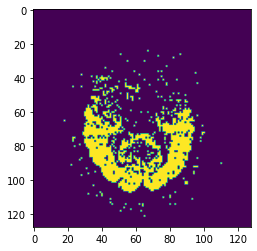

In [ ]:
# Testing for the specified slice and for one subject at a time
# Run this cell if denoising prospective DWI data
#print('Start to test on {}'.format(args.test_dir))
#out_dir = save_dir + args.test_dir.split('/')[-1] + '/'
#if not os.path.exists(out_dir):
       # os.mkdir(out_dir)
im_data=[] 
name = []
psnr = []
ssim = []
entropy_dn=[]
psnr_bm=[]
psnr_bl=[]
psnr_ad=[]
psnr_tv=[]
ssim_bm=[]
ssim_bl=[]
ssim_ad=[]
ssim_tv=[]
entropy_bl=[]
entropy_bm=[]
entropy_ad=[]
entropy_tv=[]
count=0
denoised_nifti=[]

# Read test images

for dirpath, dirnames, filenames in os.walk('../prospective_study/data/'):
    for filename in [f for f in filenames if f.endswith("b3000_avg1_full_128_sub1.nii")]:
    #for filename in [f for f in filenames if f.endswith("b3000_avg1_full_128_sub2.nii")]:
    #for filename in [f for f in filenames if f.endswith("b3000_avg1_full_128_sub3.nii")]:  
    #for filename in [f for f in filenames if f.endswith("b3000_avg2_full_128_sub1.nii")]:
    #for filename in [f for f in filenames if f.endswith("b3000_avg2_full_128_sub2.nii")]:
    #for filename in [f for f in filenames if f.endswith("b3000_avg2_full_128_sub3.nii")]:
    #for filename in [f for f in filenames if f.endswith("b3000_avg4_full_128_sub1.nii")]:
    #for filename in [f for f in filenames if f.endswith("b3000_avg4_full_128_sub2.nii")]:
    #for filename in [f for f in filenames if f.endswith("b3000_avg4_full_128_sub3.nii")]:  
        #print(os.path.join(dirpath, filename)) 
        img_path=os.path.join(dirpath, filename)
        img = nib.load(os.path.join(dirpath, filename))
        img_affine=img.affine
        x_test_nifti = np.array(img.get_data())  
        im_data.append(x_test_nifti)        
         
        # read image
        x_test_clean=x_test_nifti[:,:,69]
        x_test_clean =x_test_clean.astype('float32')           
        x_test_clean=x_test_clean/np.max(x_test_clean) # Normalize the test data                         
        x_test_noisy=x_test_clean
        
        # predict
        x_test = x_test_noisy.reshape(1, x_test_noisy.shape[0], x_test_noisy.shape[1], 1) 
        y_predict = model.predict(x_test)
        y_predict = y_predict.reshape(x_test_clean.shape)
        y_predict= np.clip(y_predict,np.min(x_test_clean),np.max(x_test_clean))
        y_predict=y_predict

        # Sharpening  
      # y_predict = cv2.medianBlur(y_predict,3)          
        un_msk=x_test_clean-y_predict #unsharp masking for medium level contrast details
        y_predict=y_predict+0.9*un_msk   # set weightage of 0.9
        denoised_nifti.append(y_predict)
        
        

      

In [ ]:
# Display images
%matplotlib inline
fig = plt.figure()  
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])       
imgplot = plt.imshow(x_test_noisy,cmap='gray')                                         
fig.suptitle('X_test_DnCNN') 
fig.colorbar(imgplot, ax=ax)

fig = plt.figure() 
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])                
imgplot = plt.imshow(y_predict,cmap='gray',vmax=1,vmin=0)        
fig.suptitle('Y_predict_DnCNN') 
fig.colorbar(imgplot, ax=ax)

fig = plt.figure() 
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])                
imgplot = plt.imshow(y_predict-x_test_clean,cmap='gray',vmax=0, vmin=-0.1)        
fig.suptitle('diffmap_denoised-original') 
fig.colorbar(imgplot, ax=ax)

fig = plt.figure() 
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([]) 
plt.imshow(x_sub10[:,:,69]-x_test_noisy,cmap='gray')     
fig.suptitle('GT-original') 
fig.colorbar(imgplot, ax=ax)


fig = plt.figure() 
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([]) 
plt.imshow(x_sub10[:,:,69]-y_predict,cmap='gray')     
fig.suptitle('GT-denoised') 
fig.colorbar(imgplot, ax=ax)




In [ ]:
#######################################
# The below cells are optional and hard coded for the current work
# We tried plotting activations maps to check whether model is learning 
###########################################



In [ ]:
# This cell is to generate activation maps
from keract import display_activations
from keract import get_activations
x = X_train1[6555]
#x= np.transpose(x)
print(x.shape)
#x=x_test_clean
#x=np.rot90(x)
x = x.reshape((x.shape[0],x.shape[1],1))
x= np.transpose(x)
# Generate the activations 
activations = get_activations(model, x)
display_activations(activations, save=False,cmap='gray')


In [ ]:
# Next six cells are creating montage of denoised slices and copying dicom header information for further proccessing
# Each denoised slice is stored as dicom files for FA map generation and hard coded for 6 directions of high b-value DWI only

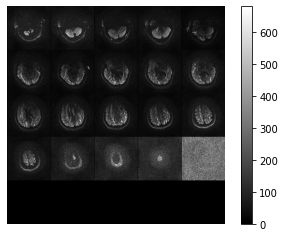

In [ ]:
# dir 1
import pylab
m=x_sub10.shape[0] 
n=x_sub10.shape[1] 
 
count = x_sub2.shape[2]     

t2=20
j=0
count2=20
j2=count2
row=5
col=5
M1 = np.zeros((row * m, col * n))

image_id = 0
for j in range(row):
    for k in range(col):
        if image_id >= count2: 
            break
        sliceM, sliceN = j * m, k * n
        M1[sliceN:sliceN + n, sliceM:sliceM + m] = x_sub10[:, :, image_id]
        image_id += 1
M1=np.fliplr(M1)   
M1=np.rot90(M1,1)  
#pix_max=np.max(x_sub1)
M1= M1*681
      
fig = pylab.figure() 
pylab.imshow(M1, cmap=pylab.cm.gist_gray)
pylab.colorbar()
pylab.axis('off')
for dirpath, dirnames, filenames in os.walk('../prospective_study/data/sub2_NEX1/'):
    for filename in [f for f in filenames if f.endswith("TEST_DWI2.MR.GEETHANATH_RECON.0005.0008.2021.04.19.17.09.41.812560.56256134.IMA")]:
        img_path=os.path.join(dirpath, filename)
        img = pydicom.read_file(img_path) 
        x_test_dicom =img.pixel_array
        pix_max=np.max(x_test_dicom)
        img.pixel_array [:,:] = M1
        arr= img.pixel_array
        img.PixelData=arr.tobytes()
        img.save_as('dir1_sub1'+filename)
       

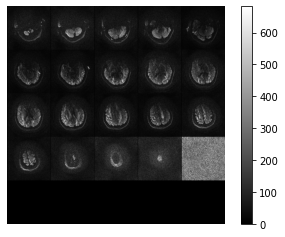

In [ ]:
# dir 2
m=x_sub10.shape[0] 
n=x_sub10.shape[1] 
 
count = x_sub2.shape[2]     
t2=t2+20
j=20
k=20
count2=40
j2=count2
row=5
col=5
M2 = np.zeros((row * m, col * n))

image_id = 20
for j in range(row):
    for k in range(col):
        if image_id >= count2: 
            break
        sliceM, sliceN = j * m, k * n
        M2[sliceN:sliceN + n, sliceM:sliceM + m] = x_sub10[:, :, image_id]
        image_id += 1
M2=np.fliplr(M2)  
M2=np.rot90(M2,1) 
M2= M2*682         
fig = pylab.figure() 
pylab.imshow(M2, cmap=pylab.cm.gist_gray)
pylab.colorbar()
pylab.axis('off')
for dirpath, dirnames, filenames in os.walk('../prospective_study/data/sub2_NEX1/'):
    for filename in [f for f in filenames if f.endswith("TEST_DWI2.MR.GEETHANATH_RECON.0005.0009.2021.04.19.17.09.41.812560.56256172.IMA")]:
        img_path=os.path.join(dirpath, filename)
        img = pydicom.read_file(img_path) 
        x_test_dicom =img.pixel_array
        img.pixel_array [:,:] = M2
        arr= img.pixel_array
        img.PixelData=arr.tobytes()
        img.save_as('dir2_sub1'+filename)


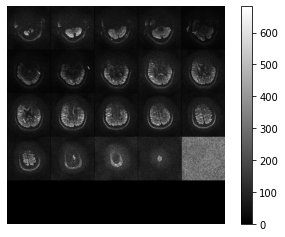

In [ ]:
# dir 3
m=x_sub10.shape[0] 
n=x_sub10.shape[1] 
t2=60
j=40
k=40
count2=60
j2=count2
row=5
col=5
M3 = np.zeros((row * m, col * n))
              
image_id = 40
for j in range(row):
    for k in range(col):
        if image_id >= count2: 
            break
        sliceM, sliceN = j * m, k * n
        M3[sliceN:sliceN + n, sliceM:sliceM + m] = x_sub2[:, :, image_id]
        image_id += 1
M3=np.fliplr(M3)  
M3=np.rot90(M3,1)   
M3= M3*682            
fig = pylab.figure() 
pylab.imshow(M3, cmap=pylab.cm.gist_gray)
pylab.colorbar()
pylab.axis('off')
for dirpath, dirnames, filenames in os.walk('../prospective_study/data/sub2_NEX1/'):
    for filename in [f for f in filenames if f.endswith("TEST_DWI2.MR.GEETHANATH_RECON.0005.0010.2021.04.19.17.09.41.812560.56256210.IMA")]:
        img_path=os.path.join(dirpath, filename)
        img = pydicom.read_file(img_path) 
        x_test_dicom =img.pixel_array        
        img.pixel_array [:,:] = M3
        arr= img.pixel_array
        img.PixelData=arr.tobytes()
        img.save_as('dir3_sub1'+filename)
#TEST_DWI.MR.GEETHANATH_DIFFUSION_DENOISING.0008.0011.2021.04.03.11.28.58.914102.917763755

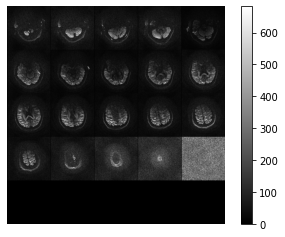

In [ ]:
# dir 4
m=x_sub10.shape[0] 
n=x_sub10.shape[1] 
t2=80
j=60
k=60
count2=80
j2=count2
row=5
col=5
M4 = np.zeros((row * m, col * n))
              
image_id = 60
for j in range(row):
    for k in range(col):
        if image_id >= count2: 
            break
        sliceM, sliceN = j * m, k * n
        M4[sliceN:sliceN + n, sliceM:sliceM + m] = x_sub10[:, :, image_id]
        image_id += 1
M4=np.fliplr(M4)  
M4=np.rot90(M4,1)    
M4= M4*682           
fig = pylab.figure() 
pylab.imshow(M4, cmap=pylab.cm.gist_gray)
pylab.axis('off')
pylab.colorbar()
for dirpath, dirnames, filenames in os.walk('../prospective_study/data/sub2_NEX1/'):
    for filename in [f for f in filenames if f.endswith("TEST_DWI2.MR.GEETHANATH_RECON.0005.0011.2021.04.19.17.09.41.812560.56256248.IMA")]:
        img_path=os.path.join(dirpath, filename)
        img = pydicom.read_file(img_path) 
        x_test_dicom =img.pixel_array
        pix_max=np.max(x_test_dicom)
        
        #M1=flipud(rot90(M1)
        img.pixel_array [:,:] = M4
        arr= img.pixel_array
        img.PixelData=arr.tobytes()
        img.save_as('dir4_sub1'+filename)


(640, 640)


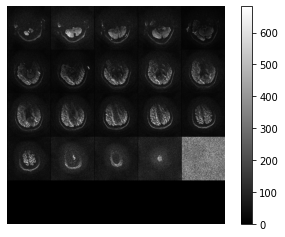

In [ ]:
# dir 5
m=x_sub10.shape[0] 
n=x_sub10.shape[1] 
t2=100
j=80
k=80
count2=100
j2=count2
row=5
col=5
M5 = np.zeros((row * m, col * n))
              
image_id = 80
for j in range(row):
    for k in range(col):
        if image_id >= count2: 
            break
        sliceM, sliceN = j * m, k * n
        M5[sliceN:sliceN + n, sliceM:sliceM + m] = x_sub10[:, :, image_id]
        image_id += 1
M5=np.fliplr(M5)
M5=np.rot90(M5,1)
M5= M5*682             
fig = pylab.figure() 
pylab.imshow(M5, cmap=pylab.cm.gist_gray)
pylab.colorbar()
pylab.axis('off')
for dirpath, dirnames, filenames in os.walk('../prospective_study/data/sub2_NEX1/'):
    for filename in [f for f in filenames if f.endswith("TEST_DWI2.MR.GEETHANATH_RECON.0005.0012.2021.04.19.17.09.41.812560.56256286.IMA")]:
        img_path=os.path.join(dirpath, filename)
        img = pydicom.read_file(img_path) 
        x_test_dicom =img.pixel_array
        img.pixel_array [:,:] = M5
        arr= img.pixel_array
        img.PixelData=arr.tobytes()
        img.save_as('dir5_sub1'+filename)
        print(M5.shape)


(640, 640)


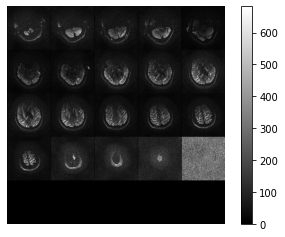

In [ ]:
# dir 6
m=x_sub10.shape[0] 
n=x_sub10.shape[1] 
t2=120
j=100
k=100
count2=120
j2=count2
row=5
col=5
M6 = np.zeros((row * m, col * n))
image_id =100
for j in range(row):
    for k in range(col):
        if image_id >= count2: 
            break
        sliceM, sliceN = j * m, k * n
        M6[sliceN:sliceN + n, sliceM:sliceM + m] = x_sub10[:, :, image_id]
        image_id += 1
M6=np.fliplr(M6)  
M6=np.rot90(M6,1)  
M6= M6*682            
fig = pylab.figure() 
pylab.imshow(M6, cmap=pylab.cm.gist_gray)
pylab.colorbar()
pylab.axis('off')
for dirpath, dirnames, filenames in os.walk('../prospective_study/data/sub2_NEX1/'):
    for filename in [f for f in filenames if f.endswith("TEST_DWI2.MR.GEETHANATH_RECON.0005.0013.2021.04.19.17.09.41.812560.56256324.IMA")]:
        img_path=os.path.join(dirpath, filename)
        img = pydicom.read_file(img_path) 
        x_test_dicom =img.pixel_array
        img.pixel_array[:,:] = M6
        arr= img.pixel_array
        img.PixelData=arr.tobytes()
        img.save_as('dir6_sub1'+filename)
